In [1]:
!git clone https://github.com/CosmoStat/jax-lensing.git
import os
os.chdir('jax-lensing')
!pip install .
os.chdir('..')
!git clone https://github.com/austinpeel/lenspack.git
os.chdir('lenspack')
!pip install .
os.chdir('..')

Cloning into 'jax-lensing'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 70 (delta 22), reused 56 (delta 13), pack-reused 0
Unpacking objects: 100% (70/70), done.
Processing /content/jax-lensing
  Created wheel for jax-lensing: filename=jax_lensing-0.1-cp36-none-any.whl size=4686 sha256=e7ecdfa2ac77ad6c945d4ddb5d9b7d4cb9f5e25e02e09665c67aa131f5daa400
  Stored in directory: /root/.cache/pip/wheels/31/5b/86/e29205d100779fcb45270ad33e29cb25072a1301b8b8f9b64e
Successfully built jax-lensing
Cloning into 'lenspack'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 533 (delta 88), reused 117 (delta 74), pack-reused 378
Receiving objects: 100% (533/533), 8.76 MiB | 4.16 MiB/s, done.
Resolving deltas: 100% (270/270), done.
Processing /content/lenspack
  Created wheel for lenspack: filename

In [21]:
import matplotlib.pyplot as plt
import jax
from jax_lensing.inversion import ks93inv
from lenspack.utils import bin2d
from astropy.table import Table
# Import the galaxy catalog
cat = Table.read('./jax-lensing/data/gal_cat.fits')
# Bin ellipticity components based on galaxy position into a 128 x 128 map
e1map, e2map = bin2d(cat['ra'], cat['dec'], v=(-cat['gamma1'], -cat['gamma2']), npix=128)

import jax.numpy as np

shear = np.stack([e1map, e2map]).flatten()

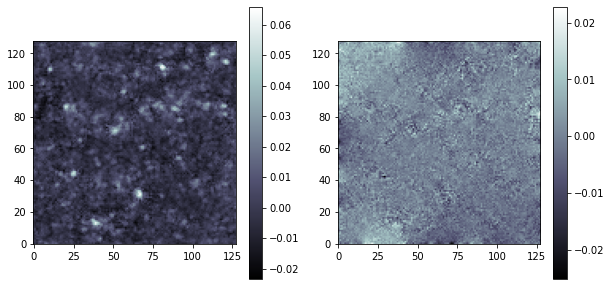

In [22]:
from jax_lensing.inversion import ks93
kappaE, kappaB = ks93(e1map, e2map)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(kappaE, origin='lower', cmap='bone')
plt.colorbar()
plt.subplot(122)
plt.imshow(kappaB, origin='lower', cmap='bone')
plt.colorbar()

true_kappa = np.stack([kappaE, kappaB]).flatten()
true_std = 0.0001*np.ones(128*128*2)

Before running the mcmc, we would like to know the range of the shear and the convergence values in order to set a smart prior and likelihood. We therefore plot the histograms of both the shear and the convergence of our toy example.

As the standard deviation of the histograms are both aroud 0.006, we round the standard deviation of the prior and the likelihood at 0.01 (we get better results as setting the standard deviations at 1).


Convergence histogram
mean -1.4551915e-11
std 0.006416811
max 0.06580218
Convergence histogram
mean -0.00066695793
std 0.0065818084
max 0.04603485


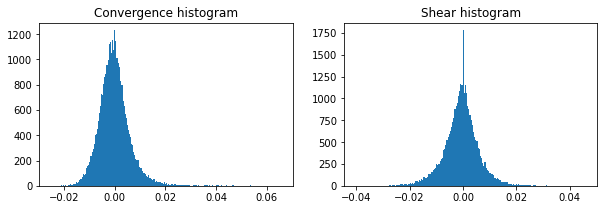

In [23]:
plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.hist(true_kappa, bins='auto')
plt.title('Convergence histogram')
print('Convergence histogram')
print('mean', np.mean(true_kappa))
print('std', np.std(true_kappa))
print('max', np.max(true_kappa))

plt.subplot(122)
plt.hist(shear, bins='auto')
plt.title('Shear histogram')
print('Convergence histogram')
print('mean', np.mean(shear))
print('std', np.std(shear))
print('max', np.max(shear))

plt.show()

In [24]:
# Deal with missing data in the shear images by setting a high variance in the corresponding location and observe how the model reacts.

coef = .01
uncertainity_mask1, uncertainity_mask2 = coef*np.ones(e1map.shape), coef*np.ones(e2map.shape)
uncertainity_mask1 = jax.ops.index_update(uncertainity_mask1, jax.ops.index[59:70, 59:70], 1e3)
uncertainity_mask2 = jax.ops.index_update(uncertainity_mask2, jax.ops.index[59:70, 59:70], 1e3)

In [25]:
!pip install --quiet --no-dependencies numpyro

import jax
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed, trace, condition, substitute
from numpyro import sample

In [26]:
def model():
    # Let's define possible ranges for the parameters
    z = sample('z', dist.Normal(loc=0., scale=.01), sample_shape=(128*128*2,)) #prior on z
    
    # Compute the Kaisr-Squires transformation
    z1, z2 = z[:z.shape[0]//2], z[z.shape[0]//2:]
    kE, kB = np.reshape(z1, (128, 128)), np.reshape(z2, (128, 128))
    gamma1, gamma2 = ks93inv(kE, kB)
    #gamma1 = mask1 * gamma1
    #gamma2 = mask2 * gamma2

    mean = np.stack([gamma1,gamma2], axis=0).flatten()
    std = np.stack([uncertainity_mask1,uncertainity_mask2], axis=0).flatten()

    # Here we define our model
    return sample('y', dist.Normal(loc=mean, scale=std))

# Before being able to take random draws we must initialize a seed
rng_key = jax.random.PRNGKey(0)
model = seed(model, rng_key)

In [27]:
# Sampling some y from this model
y_mod =  model()

In [28]:
print(y_mod.shape)

(32768,)


In [29]:
from numpyro.infer.util import log_density

In [30]:
# Now we can try to sample the model at the true parameters
true_model = substitute(model, {'z': true_kappa})#, 'std': true_std})

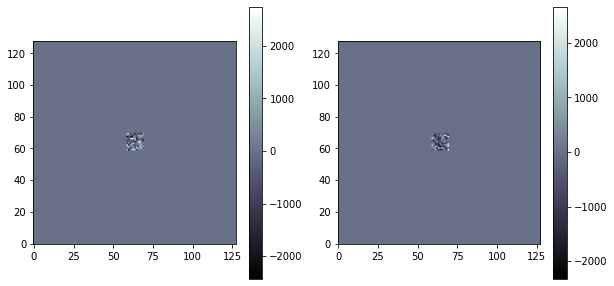

In [31]:
y_mod = true_model()
g1, g2 = y_mod[:y_mod.shape[0]//2], y_mod[y_mod.shape[0]//2:]
g1, g2 = np.reshape(g1, (128, 128)), np.reshape(g2, (128, 128))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(g1, origin='lower', cmap='bone')
plt.colorbar()
plt.subplot(122)
plt.imshow(g2, origin='lower', cmap='bone')
plt.colorbar()

In [32]:
log_p, trace = log_density(model, (), {}, {'z': true_kappa})

In [33]:
log_p

DeviceArray(215575.19, dtype=float32)

In [34]:
trace

OrderedDict([('z',
              {'args': (),
               'cond_indep_stack': [],
               'fn': <numpyro.distributions.continuous.Normal at 0x7f0d2853cdd8>,
               'infer': {},
               'intermediates': [],
               'is_observed': False,
               'kwargs': {'rng_key': array([2205739499, 3850766070], dtype=uint32),
                'sample_shape': (32768,)},
               'name': 'z',
               'scale': None,
               'type': 'sample',
               'value': DeviceArray([-0.00774595, -0.00205239, -0.00947765, ...,  0.01021568,
                             0.0065422 ,  0.00988104], dtype=float32)}),
             ('y',
              {'args': (),
               'cond_indep_stack': [],
               'fn': <numpyro.distributions.continuous.Normal at 0x7f109054c2e8>,
               'infer': {},
               'intermediates': [],
               'is_observed': False,
               'kwargs': {'rng_key': array([2336434339,  995697925], dtype=uint

In [35]:
obs_model = condition(model, {'y': shear})

In [36]:
y_mod = obs_model()

In [37]:
nuts_kernel = numpyro.infer.NUTS(obs_model)
mcmc = numpyro.infer.MCMC(nuts_kernel, 
                          num_warmup=500, 
                          num_samples=5000,
                          jit_model_args=True)

In [38]:
import time
start = time.time()
mcmc.run(rng_key)
print('\nMCMC elapsed time:', time.time() - start)

sample: 100%|██████████| 5500/5500 [02:46<00:00, 33.08it/s, 31 steps of size 1.11e-01. acc. prob=0.79]



MCMC elapsed time: 166.8868317604065


In [39]:
#mcmc.print_summary()

In [40]:
samples = mcmc.get_samples()
convergence = samples['z']

In [41]:
print(samples['z'].shape)

(5000, 32768)


In [42]:
convergence = np.mean(samples['z'][:, :], axis=0)
print(convergence.shape)

(32768,)


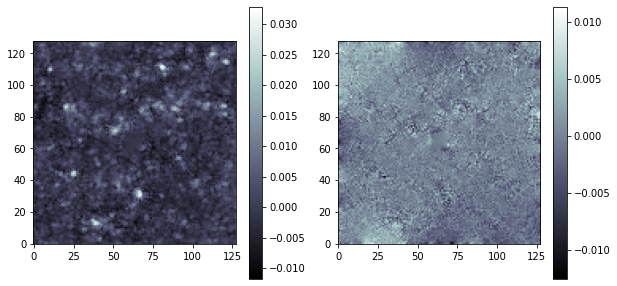

In [43]:
z1, z2 = convergence[:convergence.shape[0]//2], convergence[convergence.shape[0]//2:]
kE, kB = np.reshape(z1, (128, 128)), np.reshape(z2, (128, 128))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(kE, origin='lower', cmap='bone')
plt.colorbar()
plt.subplot(122)
plt.imshow(kB, origin='lower', cmap='bone')
plt.colorbar()
plt.savefig('hmc.png')

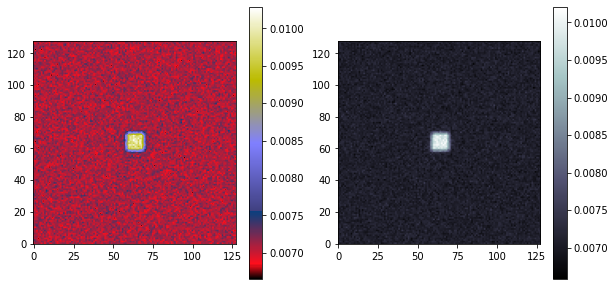

In [44]:
standatd_dev = np.std(samples['z'][:, :], axis=0)

z1, z2 = standatd_dev[:standatd_dev.shape[0]//2], standatd_dev[standatd_dev.shape[0]//2:]
kE, kB = np.reshape(z1, (128, 128)), np.reshape(z2, (128, 128))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(kE, origin='lower', cmap='gist_stern')
plt.colorbar()
plt.subplot(122)
plt.imshow(kB, origin='lower', cmap='bone')
plt.colorbar()

In [45]:
kappa_vi = np.load('jax-lensing/data/convergence_vi.npy')[0]
kappa_vi_E, kappa_vi_B = kappa_vi[:kappa_vi.shape[0]//2], kappa_vi[kappa_vi.shape[0]//2:]
kappa_vi_E, kappa_vi_B = np.reshape(kappa_vi_E, (128, 128)), np.reshape(kappa_vi_B, (128, 128))

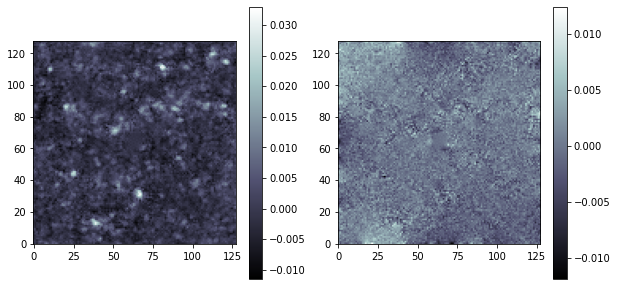

In [46]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(kappa_vi_E, origin='lower', cmap='bone')
plt.colorbar()
plt.subplot(122)
plt.imshow(kappa_vi_B, origin='lower', cmap='bone')
plt.colorbar()

Computing the bias
$$\frac{\|\kappa_{\mathrm{HMC}} - \kappa_{\mathrm{VI}}\|_2}{\|\kappa_{\mathrm{HMC}}\|_2}$$

In [47]:
#print(np.linalg.norm(kappa_vi - true_kappa)/np.linalg.norm(true_kappa))
#print(np.linalg.norm(convergence - true_kappa)/np.linalg.norm(true_kappa))
bytearray = np.linalg.norm(convergence - kappa_vi)/np.linalg.norm(convergence)
print(b)

0.21730772


Visualizing the bias

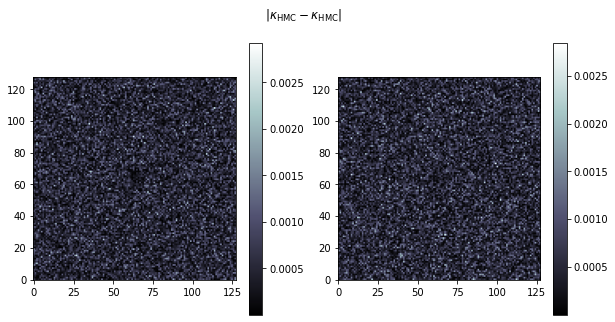

In [62]:
bias = np.abs(convergence - kappa_vi)
bias_E, bias_B = bias[:bias.shape[0]//2].reshape(128, 128), bias[bias.shape[0]//2:].reshape(128, 128)
plt.figure(figsize=(10, 5))
plt.suptitle('$\|\kappa_{\mathrm{HMC}} - \kappa_{\mathrm{HMC}}\|$')
plt.subplot(121)
plt.imshow(bias_E, origin='lower', cmap='bone')
plt.colorbar()
plt.subplot(122)
plt.imshow(bias_B, origin='lower', cmap='bone')
plt.colorbar()

NameError: ignored